### Setup

In [ ]:
LOG_TO_WANDB=True

In [ ]:
pip -q install einops

In [ ]:
pip -q install wandb

In [ ]:
# a2f3f26c75aa02b17c27fb97e690ed64b321f6cf
# Get your own token here cindy and paste it so I know which runs I did and which runs you did
#

In [ ]:
!wandb login

wandb: Currently logged in as: cindychou (regeneron-proj). Use `wandb login --relogin` to force relogin


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_folder = "/content/drive/MyDrive/regeneron-proj/"

import sys
sys.path.append(root_folder)

Mounted at /content/drive


In [ ]:
import sys
import os
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import numpy as np

import einops
import wandb

from tqdm.notebook import trange, tqdm

import utils as utils
from models.fnet import FNet
from models.transformer import Transformer
from models.vit import ClassificationViT

print(torch.__version__)
print(torchaudio.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1.12.1+cu113
0.12.1+cu113


'cuda'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
config = {}

### Data Preparation

In [ ]:
data_config = {
    "batch_size": 128
}

mfcc_config = {
    "n_fft":2048,
    "win_length":None,
    "hop_length":512,
    "n_mels":128,
    "n_mfcc":128
}

In [ ]:
# Load in data from pytorch datasets
os.makedirs("/content/data", exist_ok=True)
trainset = torchaudio.datasets.SPEECHCOMMANDS(root="/content/data", download=True, subset="training")
testset = torchaudio.datasets.SPEECHCOMMANDS("/content/data", download=True, subset="testing")

In [ ]:
# Setup Train/Test Loaders
train_loader = utils.get_train_loader(trainset, data_config["batch_size"])
test_loader = utils.get_test_loader(testset, data_config["batch_size"])

In [ ]:
# Get MFCC Transform with hyperparameters
mfcc_transform = utils.get_mfcc_transform(
    sample_rate=16000,
    n_fft = mfcc_config['n_fft'],
    win_length = mfcc_config['win_length'],
    hop_length = mfcc_config['hop_length'],
    n_mels = mfcc_config['n_mels'],
    n_mfcc = mfcc_config['n_mfcc']
)
#mfcc_transform.to(device)

In [ ]:
# Merge dataconfig with configs
config.update(data_config)
config.update(mfcc_config)

### Data Augmentation (experiment)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


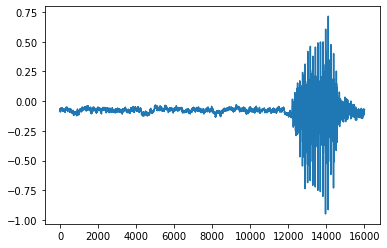

In [ ]:
import matplotlib.pyplot as plt
import librosa
waveform, sample_rate, label, speaker_id, utterance_number = trainset[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
mfcc = mfcc_transform(waveform)
mfcc.shape

torch.Size([1, 128, 32])

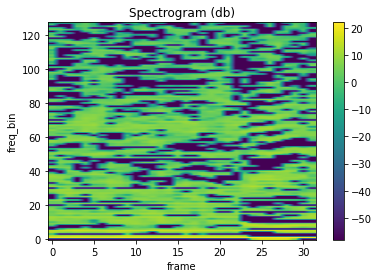

In [ ]:
mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

In [ ]:
mfcc[0].shape

torch.Size([128, 32])

In [ ]:
import cv2

In [ ]:
def add_light(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    image=cv2.LUT(image, table)
    return image

add_light(mfcc[0],2)

error: ignored

### Models

In [ ]:
fnet_configs = {
    "embedding_dim": 256,
    "feedforward_dim": 1024,
    "dropout": 0.1,
    "num_encoder_layers": 4,
}

transformer_configs = {
    "embedding_dim": 256,
    "feedforward_dim": 1024,
    "n_heads": 4,
    "num_encoder_layers": 4,
}

config.update({
    "architecture": "FAST",
    "patch_size": 4,
})

In [ ]:
# Setup FNet
fnet = FNet(
    d_model=fnet_configs["embedding_dim"],
    feedforward_dim=fnet_configs["feedforward_dim"],
    dropout=fnet_configs["dropout"],
    num_layers=fnet_configs["num_encoder_layers"]
)

In [ ]:
# Setup Transformer
transformer = Transformer(
    embedding_dim=transformer_configs["embedding_dim"],
    n_heads=transformer_configs["n_heads"],
    n_layers=transformer_configs["num_encoder_layers"],
    feedforward_dim=transformer_configs["feedforward_dim"]
)

In [ ]:
# Setup Final Model
encoder = None
if config["architecture"] == "FAST":
  config.update(fnet_configs)
  encoder = FNet(
    d_model=fnet_configs["embedding_dim"],
    feedforward_dim=fnet_configs["feedforward_dim"],
    dropout=fnet_configs["dropout"],
    num_layers=fnet_configs["num_encoder_layers"]
  )
elif config["architecture"] == "AST":
  config.update(transformer_configs)
  encoder = Transformer(
    embedding_dim=transformer_configs["embedding_dim"],
    n_heads=transformer_configs["n_heads"],
    n_layers=transformer_configs["num_encoder_layers"],
    feedforward_dim=transformer_configs["feedforward_dim"]
  )
else:
  raise ValueError("Pick a proper encoder.")

# Calculate num_patches
waveform, sample_rate, label, speaker_id, utterance_number = trainset[0]
num_patches = ClassificationViT.patchify(mfcc_transform(waveform.to(device)).unsqueeze(dim=0), config["patch_size"]).shape[1]

model = ClassificationViT(
    n_classes=35,
    transformer_encoder=encoder,
    n_channels=1,
    embedding_dim=config["embedding_dim"],
    patch_size=config["patch_size"],
    num_patches=num_patches
)

model.to(device)

ClassificationViT(
  (transformer): FNet(
    (layers): ModuleList(
      (0): FNetEncoderLayer(
        (ff): FeedForward(
          (fc1): Linear(in_features=256, out_features=1024, bias=True)
          (fc2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): FNetEncoderLayer(
        (ff): FeedForward(
          (fc1): Linear(in_features=256, out_features=1024, bias=True)
          (fc2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): FNetEncoderLayer(
        (ff): FeedForward(
          (fc1): Linear(in_features=256, out_features=1024, bias=True)
          (fc2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )

### Train/Eval

In [ ]:
# Add training hyperparameters to config
config.update({
    "lr": 0,
    "betas": (0.9, 0.98),
    "weight_decay": 1e-5,
    "epochs": 10,
    "warmup": 2000,
})

In [ ]:
# https://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.model_size = model_size
        self._rate = 0

    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [ ]:
# You may want to tune these hyperparameters to get better performance
adam = optim.AdamW(
    model.parameters(),
    lr=config["lr"],
    betas=config["betas"],
    weight_decay=config["weight_decay"]
  )
optimizer = NoamOpt(config["embedding_dim"], config["warmup"], adam)


total_steps = 0
num_epochs = config["epochs"]
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0
lr = config["lr"]

if LOG_TO_WANDB:
  # Setup weights and biases
  wandb.init(
    project="regeneron-proj",
    entity="regeneron-proj",
    config=config
  )

# Transform must live on device
epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(train_loader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(device), y.to(device)
        x = mfcc_transform(x)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item(), lr=optimizer._rate)

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

        # Log to wandb
        if LOG_TO_WANDB:
          wandb.log({'train/accuracy': accuracy.item(), 'train/loss': loss.item(), 'train/lr': optimizer._rate})

    # Validation
    val_acc = []
    model.eval()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
          x = mfcc_transform(x)
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Log to wandb
    if LOG_TO_WANDB:
      wandb.log({'val/val_accuracy': np.mean(val_acc)})

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cindychou (regeneron-proj). Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

In [ ]:
# Test
correct = utils.test(model, test_loader, device, mfcc_transform)

if LOG_TO_WANDB:
  # If you had a test set, this is how you could log it as a Summary metric
  wandb.summary['test_accuracy'] = correct / len(test_loader.dataset)
  # 🐝 Close your wandb run
  wandb.finish()


Accuracy: 9326/11005 (85%)



train/accuracy,▁▃▃▅▅▆▆▆▇▆▆▇▇▇▇▇▇█▇▇▇█▇▇▇▇█▇███▇████████
train/loss,█▆▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
train/lr,▁▅█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▅▆▇▇█████
test_accuracy,0.84743
train/accuracy,0.8785
train/loss,0.31771
train/lr,0.00077
val/val_accuracy,0.8474
